In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv

In [326]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [327]:
nombres=df.drop(['CompTotal'], axis=1).columns

In [329]:
df.isnull().values.any()

False

In [330]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

Para comprender mejor la distribución de la variable objetivo 'target' (salario), se ha generado un gráfico de densidad utilizando la función `kdeplot` de la biblioteca `seaborn`. 

El gráfico resultante muestra una *distribución asimétrica positiva*, con una mayor concentración de salarios entre 0 y 100.000 y una cola que se extiende hacia valores más altos, llegando hasta aproximadamente 400.000.

Esta visualización permite extraer las siguientes conclusiones:

- **Asimetría positiva**: La distribución presenta un sesgo hacia la derecha, lo que indica que la mayoría de los salarios son relativamente bajos, mientras que hay una menor proporción de salarios altos.
- **Valores extremos**: La cola derecha extendida sugiere la presencia de valores atípicamente altos que podrían influir en el modelo. Se considerarán estos valores como outliers y se aplicarán técnicas estadísticas para su tratamiento.
- **Concentración de datos**: La mayor densidad se observa en el rango de 0 a 100.000, lo que indica el rango de salarios más común.
- **Valores cercanos a cero**: Se observa una pequeña concentración de valores alrededor de cero, lo que requiere una investigación más profunda para determinar su naturaleza.

Estas observaciones sugieren que podría ser beneficioso aplicar transformaciones a la variable 'target' para reducir la asimetría y mejorar el rendimiento del modelo. Además, se investigará la naturaleza de los valores cercanos a cero y se aplicarán técnicas de detección y tratamiento de outliers a los valores extremos.

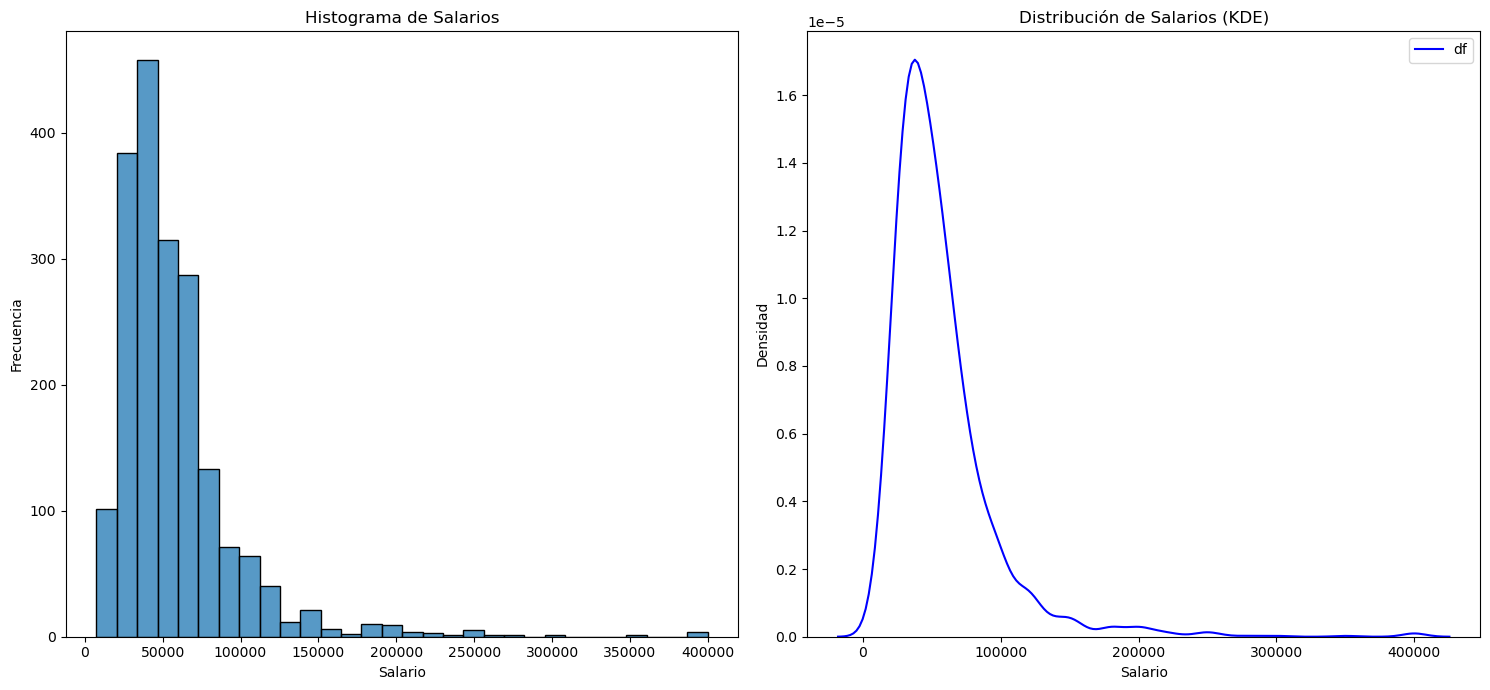

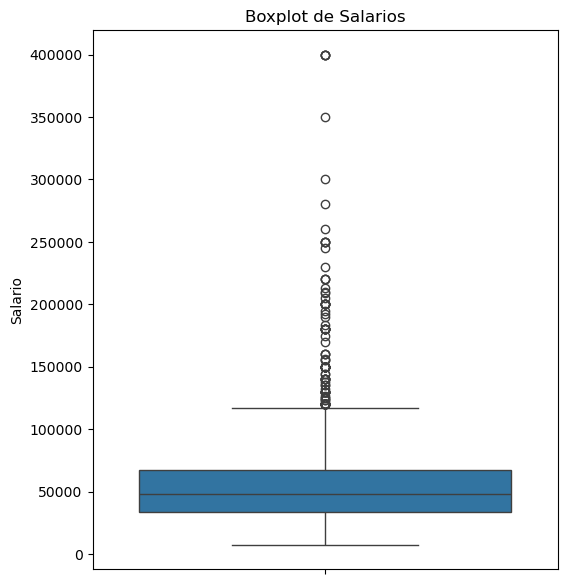

In [332]:
# 1. Histograma y gráfico de densidad
plt.figure(figsize=(15, 7))

# Histograma
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.histplot(df['CompTotal'], kde=False, bins=30)
plt.title('Histograma de Salarios')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')

# KDE Plot
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.kdeplot(df['CompTotal'], label='df', color='blue')
plt.title('Distribución de Salarios (KDE)')
plt.xlabel('Salario')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Boxplot
plt.figure(figsize=(6, 7))
sns.boxplot(y=df['CompTotal'])
plt.title('Boxplot de Salarios')
plt.ylabel('Salario')
plt.show()

**Conclusión:**
- Tanto el histograma como el KDE plot nos permiten ver que hay una distribución asimetrica positiva, con la mayor parte de los datos concentrados entre 20000 y 80000, y con una cola hacia la derecha.
- El boxplot muestra que hay algunos valores por encima del bigote superior, que podrían considerarse como outliers, como la regla del 1.5xIQR.

In [ ]:
# 3. IQR
Q1 = df['CompTotal'].quantile(0.20)
Q3 = df['CompTotal'].quantile(0.85)
IQR = Q3 - Q1
limite_inferior_iqr = Q1 - 1.5 * IQR
limite_superior_iqr = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Límite inferior (IQR): {limite_inferior_iqr}")
print(f"Límite superior (IQR): {limite_superior_iqr}")

# 4. Percentiles
percentil_1 = df['CompTotal'].quantile(0.05)
percentil_95 = df['CompTotal'].quantile(0.95)

print(f"Percentil 1: {percentil_1}")
print(f"Percentil 95: {percentil_95}")

# Del boxplot y el IQR, ya podemos identificar algunos outliers.
# Usemos ahora los límites calculados para filtrar el DataFrame

# Filtrar outliers usando IQR
df_filtrado_iqr = df[(df['CompTotal'] >= limite_inferior_iqr) & (df['CompTotal'] <= limite_superior_iqr)]

# Filtrar outliers usando percentiles
df_filtrado_percentiles = df[(df['CompTotal'] >= percentil_1) & (df['CompTotal'] <= percentil_95)]

# Comparar tamaños de los DataFrames
print(f"\nTamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado con IQR: {df_filtrado_iqr.shape}")
print(f"Tamaño del DataFrame filtrado con percentiles: {df_filtrado_percentiles.shape}")

IQR: 50000.0
Límite inferior (IQR): -45000.0
Límite superior (IQR): 155000.0
Percentil 1: 14132.0
Percentil 95: 120000.0

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado con IQR: (1888, 397)
Tamaño del DataFrame filtrado con percentiles: (1828, 397)


Para identificar y tratar los valores atípicos en la variable 'target' (salario), se han utilizado las siguientes técnicas:

1) Visualización:
- Se ha generado un histograma y un gráfico de densidad para visualizar la distribución de los salarios.
- Se ha generado un boxplot para identificar visualmente los outliers.
2) Rango Intercuartílico (IQR):
Se ha calculado el IQR y se han considerado outliers los valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR], que corresponde a [-16993.75, 117396.25].
3) Percentiles:
Se han utilizado los percentiles 1 y 95 para definir los límites inferior y superior, respectivamente. Los valores fuera del rango [14132.0, 120000.0] se han considerado outliers. 

**Interpretación y comparación:**

- IQR: Sugiere un límite superior de 155000 euros.
- Percentiles: Sugieren un rango entre 14132 y 120000 euros (con los percentiles 1 y 95).

- Elección del límite inferior:
    - El percentil 1 (14,132) está por debajo de mi límite mínimo establecido por convenio (15876,00). Usaré el límite del convenio colectivo.
- Elección del límite superior:
    - El IQR da un límite superior más alto (155,000) que el percentil 95 (120,000).
    - Teniendo en cuenta el análisis visual del gráfico de densidad, éste sugiere que la "cola" empieza alrededor de 150,000.
    - Usar 120000 euros como límite superior parece un valor razonable que permite eliminar una buena parte de los outliers, eliminando tan solo el 5% de los datos, por lo que usaré el método del percentil. 

Como resultado del análisis, y como se puede ver en los gráficos, se ha decidido utilizar el método percentil para la eliminación de outliers, ya que proporciona un equilibrio entre la eliminación de valores extremos y la conservación de datos. 

Respecto del minimo, para la variable target por restricción del rubro es de 15.876,00 (por ser el salario mínimo por convenio aplicable) se ha decidido utilizar el método del percentil, pero tomando 15876,00 como minimo, y 120000.0 como máximo. Se han eliminado 176 valores, lo que representa un 9.1% del total de datos. La decisión de utilizar este método y este porcentaje de eliminación se basa en la observación de que los valores eliminados se encuentran en las colas de la distribución y su inclusión podría afectar negativamente el rendimiento del modelo.

In [334]:
limite_inferior = 15000
limite_superior = 100000

df_filtrado = df[(df['CompTotal'] >= limite_inferior) & (df['CompTotal'] <= limite_superior)]

print(f"Tamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado: {df_filtrado.shape}")

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado: (1769, 397)


In [335]:
df = df_filtrado

In [336]:
y = df['CompTotal']

In [337]:
df = df.drop(columns=['CompTotal'], axis=1)

In [338]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [339]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [267]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# Crear el modelo LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression')

# Definir un espacio de búsqueda más amplio
param_distributions = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 70, 100, 120],
    'max_depth': [2, 3, 4, 5, -1],
    'num_leaves': [15, 31, 63, 127, 255],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [1, 2, 5, 10, 15, 20],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1, 2]
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model,
                                   param_distributions=param_distributions,
                                   n_iter=200,  # Aumentar el número de iteraciones
                                   scoring='neg_mean_squared_error',
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

# Ajustar RandomizedSearchCV a los datos de entrenamiento
random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", random_search.best_params_)

# Mejor modelo
best_lgb_model = random_search.best_estimator_

y_pred = best_lgb_model.predict(X_test) 

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 1415, number of used features: 395
[LightGBM] [Info] Start training from score 48417.332862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [268]:
import xgboost as xgb
# Crear un modelo de XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # objective es importante para problemas de regresión

param_grid = {
    'max_depth': [5],
    'learning_rate': [0.05],
    'n_estimators': [300],
    'colsample_bytree': [0.7],
    'subsample': [0.7],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

# Evaluar el mejor modelo
y_pred = best_xgb_model.predict(X_test)    

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
MSE: 143364784.75
RMSE: 11973.50
MAE: 9095.06
R²: 0.68


In [269]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 50, 100]
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", random_search.best_params_)
best_xgb_model = random_search.best_estimator_

# Evaluar el mejor modelo
y_pred = best_xgb_model.predict(X_test)    

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Mejores hiperparámetros: {'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.5}
MSE: 153884399.38
RMSE: 12405.02
MAE: 9467.54
R²: 0.66


In [270]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Crear el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Número de particiones en validación cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
best_rf_model = random_search.best_estimator_

# Evaluar el mejor modelo
y_pred = best_rf_model.predict(X_test)    

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
156 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constr

Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
MSE: 212042649.68
RMSE: 14561.68
MAE: 11368.65
R²: 0.53


In [345]:
# Crear el modelo CatBoost
# Definir una grilla de hiperparámetros
best_params = {'colsample_bylevel': 0.7, 
              'depth': 7, 
              'grow_policy': 'Depthwise', 
              'iterations': 300, 
              'l2_leaf_reg': 7, 
              'learning_rate': 0.05, 
              'max_bin': 128, 
              'min_child_samples': 1, 
              'subsample': 0.6,
              'random_seed' : 42, 
              'loss_function' : 'RMSE', 
              'verbose' : 0
              }
# Crear el modelo CatBoost
catboost_model = CatBoostRegressor(**best_params)

# Entrenar el modelo 
catboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = catboost_model.predict(X_test)

# --- Evaluación del Modelo ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

MSE: 136235543.56
RMSE: 11672.00
MAE: 8917.17
R²: 0.70
MAPE: 20.35


In [ ]:
# --- Importancia de las Características (si es necesario) ---
feature_importances = catboost_model.get_feature_importance()

# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': nombres,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Seleccionar las N características más importantes (por ejemplo, las 10 principales)
top_features = importance_df['Feature'].head(50).tolist()  # Cambia el número según desees

# Filtrar los DataFrames de entrenamiento y prueba para incluir solo las características seleccionadas

# Si tienes los nombres de las columnas originales:
X_train = pd.DataFrame(X_train, columns=nombres)
X_test = pd.DataFrame(X_test, columns=nombres)

# Ahora ya puedes usar .loc:
X_train_top = X_train.loc[:, top_features]
X_test_top = X_test.loc[:, top_features]

# Entrenar un nuevo modelo con las características más importantes

catboost_model.fit(X_train_top, y_train)

# Hacer predicciones sobre el conjunto de prueba con el nuevo modelo
y_pred_top = catboost_model.predict(X_train_top)

# Evaluar el nuevo modelo
mse_top = mean_squared_error(y_test, y_pred_top)
rmse_top = np.sqrt(mse_top)
mae_top = mean_absolute_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)
mape_top = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n--- Evaluación con las características más importantes ---")
print(f"MSE: {mse_top:.2f}")
print(f"RMSE: {rmse_top:.2f}")
print(f"MAE: {mae_top:.2f}")
print(f"R²: {r2_top:.2f}")
print(f"MAPE: {mape_top:.2f}")

In [272]:
# Espacio de búsqueda de hiperparámetros
param_distributions = {
    'colsample_bylevel': [0.9],
    'depth': [6, 8, 10],
    'grow_policy': ['Lossguide'],
    'iterations': [1000],
    'l2_leaf_reg': [1],
    'learning_rate': [0.05],
    'max_bin': [350, 400, 450],
    'min_child_samples': [10],
    'subsample': [1.0],
    'random_seed': [42],
    'loss_function': ['RMSE'],  # Fijado para regresión
    'verbose': [0]  # Fijado para evitar salida de texto
}

# Crear el modelo base
catboost_model = CatBoostRegressor()
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=10,  # Número de particiones para validación cruzada
    n_jobs=-1  # Usa todos los núcleos disponibles
)
# Ajustar RandomizedSearchCV al conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", random_search.best_params_)

# --- Evaluación con los mejores hiperparámetros ---
best_model = random_search.best_estimator_

# Predicciones sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros: {'verbose': 0, 'subsample': 1.0, 'random_seed': 42, 'min_child_samples': 10, 'max_bin': 350, 'loss_function': 'RMSE', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Lossguide', 'depth': 10, 'colsample_bylevel': 0.9}
MSE: 134893030.91
RMSE: 11614.35
MAE: 8876.97
R²: 0.70
MAPE: 20.29


In [276]:
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False) 
# Espacio de búsqueda de hiperparámetros
param_distributions = {
    'colsample_bylevel': [0.7, 0.8, 1.0],
    'depth': [4, 6, 8, 10],
    'grow_policy': ['Lossguide', 'Depthwise'],
    'iterations': [200, 400, 600],
    'l2_leaf_reg': [0.1, 1, 3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_bin': [200, 300, 400],
    'min_child_samples': [10, 15, 20],
    'subsample': [0.6, 0.8, 1.0],
    'random_seed': [42],
    'loss_function': ['RMSE'],
    'verbose': [0],
    'early_stopping_rounds': [50, 100],
    'task_type': ['CPU'],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', 'No'],
    'bagging_temperature': [0, 0.5, 1],
    'leaf_estimation_method': ['Newton', 'Gradient']
}

# Crear el modelo base
catboost_model = CatBoostRegressor()
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=200,  # Número de combinaciones a probar
    scoring=rmse_scorer,  # Métrica de evaluación
    cv=10,  # Número de particiones para validación cruzada
    n_jobs=-1  # Usa todos los núcleos disponibles
)
# Ajustar RandomizedSearchCV al conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", random_search.best_params_)

# --- Evaluación con los mejores hiperparámetros ---
best_model = random_search.best_estimator_

# Predicciones sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
370 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
  File "c:\Users\emita\.conda\envs\pr

Mejores hiperparámetros: {'verbose': 0, 'task_type': 'CPU', 'subsample': 1.0, 'random_seed': 42, 'min_child_samples': 15, 'max_bin': 200, 'loss_function': 'RMSE', 'learning_rate': 0.1, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 5, 'iterations': 600, 'grow_policy': 'Depthwise', 'early_stopping_rounds': 100, 'depth': 6, 'colsample_bylevel': 0.8, 'bootstrap_type': 'MVS', 'bagging_temperature': 1}
MSE: 140029052.07
RMSE: 11833.39
MAE: 9026.53
R²: 0.69
MAPE: 20.64


In [320]:
# Hiperparámetros especificados
params = {
    'verbose': 0,
    'subsample': 1.0,
    'random_seed': 100,
    'min_child_samples': 15,
    'max_bin': 200,
    'loss_function': 'RMSE',
    'learning_rate': 0.1,
    'leaf_estimation_method': 'Newton',
    'l2_leaf_reg': 5,
    'iterations': 600,
    'grow_policy': 'Depthwise',
    'early_stopping_rounds': 100,
    'depth': 6,
    'colsample_bylevel': 0.8,
    'bootstrap_type': 'MVS',
    'bagging_temperature': 1
}

# Crear el modelo CatBoost con los hiperparámetros
model = CatBoostRegressor(**params)

model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

MSE: 142786223.97
RMSE: 11949.32
MAE: 9207.21
R²: 0.69
MAPE: 20.81
